# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import lsst.daf.butler as daf_butler
from lsst.obs.lsst import LsstCam, LsstTS8
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import lsst.geom
from lsst.afw import cameraGeom
from lsst.obs.lsst import LsstCam
import pandas as pd
# import lsst.eo.pipe as eo_pipe
# import lsst.pipe

In [2]:
def plot_focal_plane(ax, amp_data, camera=None, cm=plt.cm.hot,
                     x_range=None, y_range=None,
                     z_range=None, use_log10=False, scale_factor='1',
                     title='', nsigma=4):
    """
    Make a "heat map" plot of the focalplane using per-amplifier values.

    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    amp_data: dict of dict of floats
        Dictionary of dictionary of amplifier values to render,
        keyed by detector name, e.g., 'R01_S00' and then by channel ID,
        e.g., 'C00'.
    camera: `lsst.afw.cameraGeom.camera.camera.Camera` [None]
        Camera object containing the detector info. If None, use
        `lsst.obs.lsst.LsstCam.getCamera()`
    cm: `matplotlib.colors.Colormap`
        Colormap used to render amplifier values.
    x_range: tuple [None]
        Focalplane plotting region in x-direction in units of mm.
        If None, then the region will be inferred from the camera.
    y_range: tuple [None]
        Focalplane plotting region in y-direction in units of mm.
        If None, then the region will be inferred from the camera.
    z_range: 2-tuple of floats or `str` [None]
        Minimum and maximum values into which to map the unit interval
        for the color map.  Values are mapped using
        max(0, min(1, (amp_value - z_range[0])/(z_range[1] - z_range[0])))
        If None, then use
           z_range = (min(amp_data.values(), max(amp_data.values())
        If "clipped_autoscale", then use
           z_range = get_median_nsigma_range(amp_data, nsigma=nsigma,
                                             use_log10=use_log10)
    use_log10: bool [False]
        If True, then use log10(amp_value) for positive amp_value.  For
        non-positive amp_value, don't render the amp color.
    scale_factor: str ['1']
        Scale factor to apply to the colorbar mapping.  This value
        will be cast as a float when applied to the tick label values.  It
        is passed as a string so that formatting in the colorbar tick
        labels can be controlled directly by the client code.
        This is not used if use_log10 == True.
    title: str ['']
        Title to apply to the plot.
    nsigma: float [4]
        Number of sigma to apply to clipped stdev for an "autoscaled"
        z_range, i.e., [median - nsigm*stdev_clip, median + nsigm*stdev_clip].

    Returns
    -------
    None
    """
    xy_ranges = {'LSSTCam': (-325, 325),
                 'LSST-TS8': (-70, 70)}
    if camera is None:
        camera = LsstCam.getCamera()
    fp_radius = camera.computeMaxFocalPlaneRadius()
    if x_range is None:
        x_range = xy_ranges.get(camera.getName(), (-fp_radius, fp_radius))
    if y_range is None:
        y_range = xy_ranges.get(camera.getName(), (-fp_radius, fp_radius))
    plot_amp_boundaries(ax, camera=camera)
    if z_range is None:
        z_range_values = []
        for _ in amp_data.values():
            z_range_values.extend(_.values())
        if use_log10:
            z_range_values = [np.log10(_) for _ in z_range_values if _ > 0]
        z_range = min(z_range_values), max(z_range_values)
    elif z_range == 'clipped_autoscale':
        z_range = get_median_nsigma_range(amp_data, nsigma=nsigma,
                                          use_log10=use_log10)
    for det_name, amp_values in amp_data.items():
        plot_det(ax, camera[det_name], amp_values, cm=cm, z_range=z_range,
                 use_log10=use_log10)
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    norm = plt.Normalize(vmin=z_range[0], vmax=z_range[1])
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    ax.set_title(title)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    colorbar = plt.colorbar(sm, cax=cax)
    if use_log10:
        ticks = sorted(list(set([int(_) for _ in
                                 np.log10(np.logspace(0, z_range[1]))])))
        ticklabels = [10**_ for _ in ticks]
        colorbar.set_ticks(ticks)
        colorbar.set_ticklabels(ticklabels)
    elif scale_factor != '1':
        ticks = colorbar.get_ticks()
        colorbar.set_ticks(ticks)
        ticklabels = [_/float(scale_factor) for _ in ticks]
        ticklabels[-1] = '{} x {}'.format(ticklabels[-1], scale_factor)
        colorbar.set_ticklabels(ticklabels)
    ax.set_aspect('equal')
    return colorbar


def plot_det(ax, det, amp_values, cm=plt.cm.hot, z_range=None, use_log10=False):
    """
    Plot the amplifiers in a detector, rendering each amplier region with
    a color corresponding to its assigned value.

    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    det: `lsst.afw.cameraGeom.detector.detector.Detector`
        Detector object.
    amp_values: dict of floats
        Dictionary of amplifier values to render, keyed by channel ID,
        e.g., 'C00', 'C01', etc.
    cm: `matplotlib.colors.Colormap`
        Colormap used to render amplifier values.
    z_range: 2-tuple of floats [None]
        Minimum and maximum values into which to map the unit interval
        for the color map.  Values are mapped using
        max(0, min(1, (amp_value - z_range[0])/(z_range[1] - z_range[0])))
        If None, then use
        z_range = (min(amp_values.values()), max(amp_values.values()))
    use_log10: bool [False]
        If True, then use log10(amp_value) for positive amp_value.  For
        non-positive amp_value, don't render the amp color.

    Returns
    -------
    None
    """
    if z_range is None:
        zvals = amp_values.values()
        z_range = min(zvals), max(zvals)

    def mapped_value(amp_value):
        return max(0, min(1., ((amp_value - z_range[0])
                               / (z_range[1] - z_range[0]))))

    my_facecolors = []
    for amp in det:
        if amp.getName() not in amp_values:
            continue
        if use_log10:
            if amp_values[amp.getName()] <= 0:
                my_facecolors.append(None)
            else:
                my_facecolors.append(
                    cm(mapped_value(np.log10(amp_values[amp.getName()]))))
        else:
            my_facecolors.append(cm(mapped_value(amp_values[amp.getName()])))

    my_patches = get_amp_patches(det, amp_values)
    facecolors, patches = [], []
    for facecolor, patch in zip(my_facecolors, my_patches):
        if facecolor is not None:
            facecolors.append(facecolor)
            patches.append(patch)
    assert len(facecolors) == len(patches)
    pc = PatchCollection(patches, facecolors=facecolors)
    ax.add_collection(pc)

def get_amp_patches(det, amps=None):
    """
    Return a list of Rectangle patches in focalplane coordinates
    corresponding to the amplifier segments in a detector object.

    Parameters
    ----------
    det: `lsst.afw.cameraGeom.detector.detector.Detector`
        Detector object.
    amps: container-type object [None]
        Python container that can be queried like `'C01 in amps'`
        to see if a particular channel is included for plotting.
        If None, then use all channels in det.

    Returns
    -------
    list of matplotlib.patches.Rectangle objects
    """
    transform = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    bbox = list(det)[0].getBBox()
    dy, dx = bbox.getHeight(), bbox.getWidth()
    patches = []
    for amp in det:
        if amps is not None and amp.getName() not in amps:
            continue
        j, i = tuple(int(_) for _ in amp.getName()[1:])
        y, x = j*dy, i*dx
        x0, y0 = transform.applyForward(lsst.geom.Point2D(x, y))
        x1, y1 = transform.applyForward(lsst.geom.Point2D(x + dx, y + dy))
        patches.append(Rectangle((x0, y0), x1 - x0, y1 - y0))
    return patches


def plot_amp_boundaries(ax, camera=None, edgecolor='blue', facecolor='white'):
    """
    Plot the amplifier boundaries for all of the detectors in a camera.

    Parameters
    ----------
    ax: `matplotlib.Axes`
        Axes object used to render the patch collection containing
        the amplifier boundary Rectangles.
    camera: `lsst.afw.cameraGeom.camera.camera.Camera` [None]
        Camera object containing the detector info. If None, use
        `lsst.obs.lsst.LsstCam.getCamera()`
    edgecolor: str or tuple of RGBA values ["blue"]
        Color used to draw outline of amplifiers.
    facecolor: str or tuple of RGBA values ["white"]
        Color used to render the Rectangle corresponding to the
        amplifier region.

    Returns
    -------
    None
    """
    if camera is None:
        camera = LsstCam.getCamera()
    patches = []
    for det in camera:
        patches.extend(get_amp_patches(det))
    pc = PatchCollection(patches, edgecolor=edgecolor, facecolor=facecolor)
    ax.add_collection(pc)

def get_amp_data(repo, collections, camera=None,kw='eo_read_noise'):
    """Return amp-level read noise data"""
    if camera is None:
        camera = LsstCam.getCamera()
    butler = daf_butler.Butler(repo, collections=collections)
    dsrefs = list(set(butler.registry.queryDatasets(kw,
                                                    findFirst=True)))
    amp_data = {'read_noise': defaultdict(dict),
                'bias_level': defaultdict(dict)}
    for dsref in dsrefs:
        det = camera[dsref.dataId['detector']]
        det_name = det.getName()
        for amp in det:
            amp_name = amp.getName()
            df = butler.get(dsref).query(f"amp_name=='{amp_name}'")
            for column in amp_data:
                try:
                    amp_data[column][det_name][amp_name] = np.median(df[column])
                except KeyError:
                    continue
    amp_data = {key: dict(value) for key, value in amp_data.items()}
    return amp_data

# Try to reproduce/understand the pixel list that goes into this eo_pipe result
https://s3df.slac.stanford.edu/data/rubin/lsstcam/13547/w_2023_41/dark_pixels_fp_plot_LSSTCam_u_lsstccs_eo_dark_defects_13547_w_2023_41_20231116T191705Z.png


And then you could focus on the pixels flagged as "Bright" and "Dark" and those columns flagged as "Bright" and "Dark"

In [3]:
# For Run 6, we'll use the '/repo/ir2' butler repository.  We've analyzed the Run 5 data using '/repo/main'.
repo = '/repo/ir2'
# The shifters will run the cp_pipe and eo_pipe pipelines using the lsstccs group account.  For our setups,
# environment variables will be used to specify the runs to analyze and the weekly version of the LSST stack
# to run.  The collection names of the outputs will be composed of the operator, run number, and weekly version.
operator = 'lsstccs'
acq_runs = ['13391','13401','13505','13550']  # Run 6, run 6b.
weeklys = ['w_2023_24','w_2023_41']

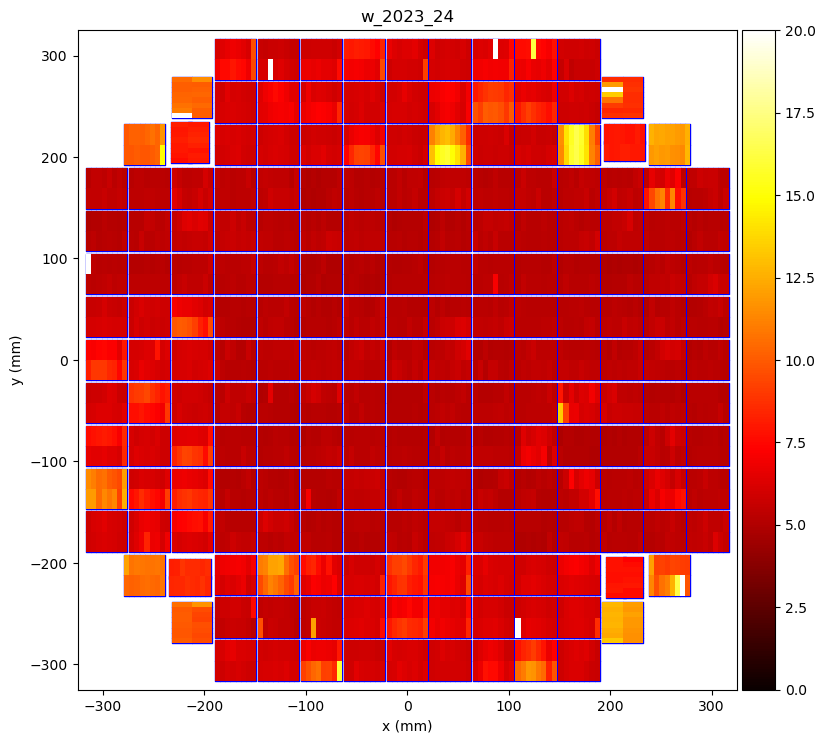

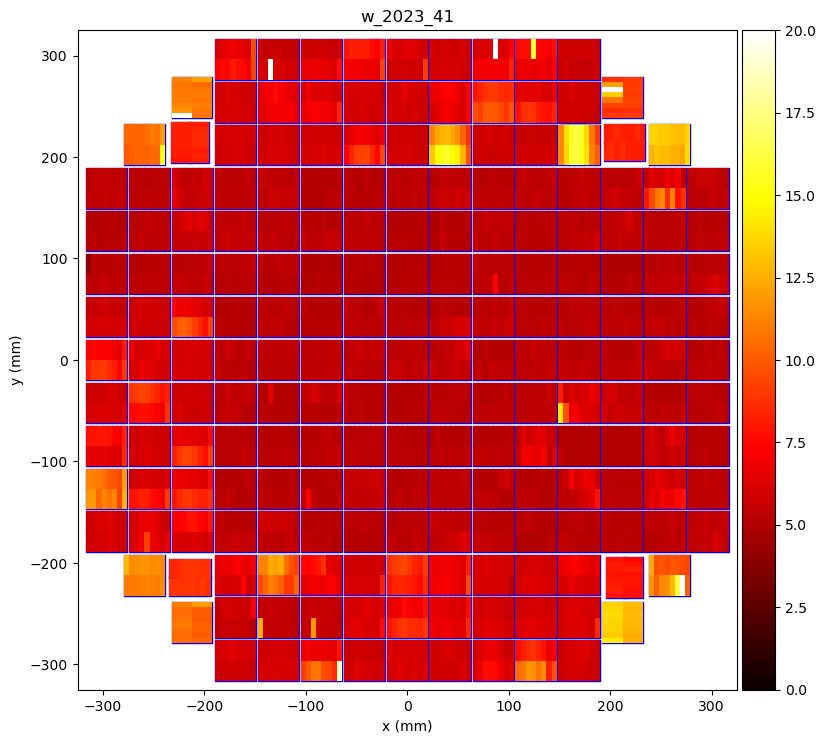

In [4]:
# We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
# the specified run.  For our dataset queries, we'll use these collections.
butler = daf_butler.Butler(repo)
for run_iter in range(len(acq_runs)):
    acq_run,weekly = acq_runs[run_iter],weeklys[run_iter]
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)
    # for item in collections:
    #     print(item)
    # print()

    amp_data = get_amp_data(repo, collections)
    
    plt.figure(figsize=(9, 9))
    ax = plt.gca()
    plot_focal_plane(ax, amp_data['read_noise'], z_range=(0, 20),title=weekly);

    plt.show()

plt.close()

In [5]:
amp_data = get_amp_data(repo, collections)
for quantity in amp_data.keys():
    print(quantity)

read_noise
bias_level


In [6]:
list(amp_data['read_noise'].keys())

['R22_S20',
 'R24_S12',
 'R20_S21',
 'R03_S01',
 'R21_S12',
 'R34_S02',
 'R04_SG0',
 'R21_S00',
 'R12_S02',
 'R21_S21',
 'R34_S10',
 'R01_S20',
 'R22_S21',
 'R04_SW1',
 'R42_S12',
 'R40_SG1',
 'R41_S21',
 'R41_S02',
 'R31_S00',
 'R44_SG0',
 'R01_S12',
 'R13_S21',
 'R32_S11',
 'R11_S21',
 'R30_S11',
 'R10_S02',
 'R03_S22',
 'R10_S12',
 'R23_S11',
 'R22_S02',
 'R12_S10',
 'R34_S11',
 'R31_S11',
 'R23_S22',
 'R22_S00',
 'R44_SW0',
 'R02_S20',
 'R33_S11',
 'R30_S02',
 'R01_S02',
 'R14_S21',
 'R43_S12',
 'R02_S01',
 'R33_S22',
 'R41_S01',
 'R13_S00',
 'R42_S00',
 'R14_S20',
 'R43_S21',
 'R30_S12',
 'R22_S01',
 'R23_S01',
 'R32_S02',
 'R31_S20',
 'R02_S22',
 'R21_S11',
 'R03_S10',
 'R03_S11',
 'R32_S01',
 'R02_S11',
 'R24_S10',
 'R22_S22',
 'R11_S12',
 'R10_S00',
 'R43_S02',
 'R20_S01',
 'R24_S01',
 'R23_S02',
 'R34_S22',
 'R21_S02',
 'R33_S20',
 'R20_S22',
 'R34_S21',
 'R12_S21',
 'R10_S01',
 'R22_S10',
 'R03_S12',
 'R21_S01',
 'R31_S21',
 'R11_S00',
 'R30_S00',
 'R33_S01',
 'R24_S21',
 'R2

In [7]:
list(amp_data['read_noise'].keys())

['R22_S20',
 'R24_S12',
 'R20_S21',
 'R03_S01',
 'R21_S12',
 'R34_S02',
 'R04_SG0',
 'R21_S00',
 'R12_S02',
 'R21_S21',
 'R34_S10',
 'R01_S20',
 'R22_S21',
 'R04_SW1',
 'R42_S12',
 'R40_SG1',
 'R41_S21',
 'R41_S02',
 'R31_S00',
 'R44_SG0',
 'R01_S12',
 'R13_S21',
 'R32_S11',
 'R11_S21',
 'R30_S11',
 'R10_S02',
 'R03_S22',
 'R10_S12',
 'R23_S11',
 'R22_S02',
 'R12_S10',
 'R34_S11',
 'R31_S11',
 'R23_S22',
 'R22_S00',
 'R44_SW0',
 'R02_S20',
 'R33_S11',
 'R30_S02',
 'R01_S02',
 'R14_S21',
 'R43_S12',
 'R02_S01',
 'R33_S22',
 'R41_S01',
 'R13_S00',
 'R42_S00',
 'R14_S20',
 'R43_S21',
 'R30_S12',
 'R22_S01',
 'R23_S01',
 'R32_S02',
 'R31_S20',
 'R02_S22',
 'R21_S11',
 'R03_S10',
 'R03_S11',
 'R32_S01',
 'R02_S11',
 'R24_S10',
 'R22_S22',
 'R11_S12',
 'R10_S00',
 'R43_S02',
 'R20_S01',
 'R24_S01',
 'R23_S02',
 'R34_S22',
 'R21_S02',
 'R33_S20',
 'R20_S22',
 'R34_S21',
 'R12_S21',
 'R10_S01',
 'R22_S10',
 'R03_S12',
 'R21_S01',
 'R31_S21',
 'R11_S00',
 'R30_S00',
 'R33_S01',
 'R24_S21',
 'R2

In [8]:
amp_data['read_noise']['R00_SG1']

{'C10': 11.409877314818194,
 'C11': 10.950774438651916,
 'C12': 11.032547473457656,
 'C13': 11.192563171586933,
 'C14': 11.166902301788253,
 'C15': 10.947065991434375,
 'C16': 10.79164829343819,
 'C17': 10.982389469546181,
 'C07': 12.869419103000215,
 'C06': 11.408257807168166,
 'C05': 11.508138486087429,
 'C04': 11.728179025569627,
 'C03': 11.65800060590645,
 'C02': 11.450057410061156,
 'C01': 11.497885593731318,
 'C00': 11.348642225652446}

In [9]:
dstypes = ('bright_defects_results', 'dark_defects_results')

In [10]:
# Because of how the parallelization works with LSST middleware, some of the pipeline algorithms produce
# output separate data frames for each CCD.  Other algorithms work on all of the CCDs in one process, so 
# produce a single data frame for the entire focal plane.
#
# Here we loop over the datasets and print out the .info() for the datasets that are data frames.  Some
# of the datasets return zero references since they are derived from the PTC analysis in cp_pipe, and
# that pipeline was run on the densely sampled PTC data in run 13144.

butler = daf_butler.Butler(repo, collections=collections)

for i, dstype in enumerate(dstypes, 1):
    refs = list(set(butler.registry.queryDatasets(dstype, findFirst=True).expanded()))
    print(i, dstype, len(refs), end='  ')
    if not refs:  # No data products found for this dataset type for this run.
        print()
        continue
    ds = butler.get(refs[0])
    if isinstance(ds, pd.DataFrame):
        print(ds.info())
    print()



1 bright_defects_results 1  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   det_name        3216 non-null   object
 1   amp_name        3216 non-null   object
 2   bright_columns  3216 non-null   int64 
 3   bright_pixels   3216 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 100.6+ KB
None

2 dark_defects_results 1  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   det_name      3216 non-null   object
 1   amp_name      3216 non-null   object
 2   dark_columns  3216 non-null   int64 
 3   dark_pixels   3216 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 100.6+ KB
None



In [11]:
ds

,det_name,amp_name,dark_columns,dark_pixels
0,R01_S00,C10,0,2047
1,R01_S00,C11,0,2052
2,R01_S00,C12,0,2081
3,R01_S00,C13,0,2676
4,R01_S00,C14,24,4486
...,...,...,...,...
3211,R44_SW1,C13,0,1594
3212,R44_SW1,C14,0,1603
3213,R44_SW1,C15,0,1625
3214,R44_SW1,C16,0,1670


In [12]:
def getDetectors(df):
    return np.unique(np.array(df['det_name'],dtype=str))

In [13]:
for id in getDetectors(ds):
    print(id, sum(ds[ds['det_name']==id]['dark_pixels']))

R00_SG0 33772
R00_SG1 32186
R00_SW0 12445
R00_SW1 13660
R01_S00 159121
R01_S01 33255
R01_S02 31264
R01_S10 22106
R01_S11 24798
R01_S12 21462
R01_S20 24411
R01_S21 20763
R01_S22 25031
R02_S00 24524
R02_S01 24376
R02_S02 24368
R02_S10 24242
R02_S11 24799
R02_S12 24403
R02_S20 20374
R02_S21 24316
R02_S22 22203
R03_S00 17811
R03_S01 17524
R03_S02 99425
R03_S10 17355
R03_S11 16411
R03_S12 17356
R03_S20 24482
R03_S21 16367
R03_S22 16878
R04_SG0 426753
R04_SG1 33192
R04_SW0 16347
R04_SW1 12237
R10_S00 169577
R10_S01 19827
R10_S02 24979
R10_S10 24460
R10_S11 26015
R10_S12 24445
R10_S20 24341
R10_S21 15751
R10_S22 24843
R11_S00 31994
R11_S01 33034
R11_S02 32889
R11_S10 32970
R11_S11 33470
R11_S12 32740
R11_S20 33414
R11_S21 32810
R11_S22 32891
R12_S00 25688
R12_S01 25970
R12_S02 28061
R12_S10 26882
R12_S11 26925
R12_S12 26430
R12_S20 27881
R12_S21 25662
R12_S22 27951
R13_S00 28360
R13_S01 31872
R13_S02 28621
R13_S10 26970
R13_S11 27908
R13_S12 27288
R13_S20 27418
R13_S21 27047
R13_S22 26881
R14

# Real stuff

In [18]:
def acq_parser(acq):
    if acq == '13550' or acq == '13505':
        return "Run6b_"
    elif acq == '13401' or acq == '13391':
        return "Run6_"
    else:
        return -1

def dstype_parser(id):
    if id== "BrightPixels":
        return 'bright_pixels'
    elif id =='DarkPixels':
        return 'dark_pixels'
    elif id == 'BrightColumns':
        return 'bright_columns'
    elif id == 'DarkColumns':
        return 'dark_columns'
    else: 
        return -1

def dstype_indexer(id):
    if id=="dark_defects_results":
        return ["dark_pixels",'dark_columns']
    elif id=="bright_defects_results":
        return ["bright_pixels",'bright_columns']
    else:
        return -1

def get_serial_from_number(numbers):
    camera = LsstCam.getCamera()
    number_arr = np.array([],dtype=str)
    for number in numbers:
        number_arr = np.append(number_arr,camera.getIdMap()[number].getSerial()[:3])
    return number_arr

def getDetectorSize(numbers):
    camera = LsstCam.getCamera()
    size_arr = np.empty(len(numbers),dtype=int)
    for number in numbers:
        size_arr[number] = camera.getIdMap()[number].getBBox().getDimensions().getY() * camera.getIdMap()[number].getBBox().getDimensions().getX()
    return size_arr

def getDetectorNumber(detectorNames):
    camera = LsstCam.getCamera()
    det_nums = {det.getName():i for i, det in enumerate(camera)}
    detector_numbers = np.empty(len(detectorNames),dtype=int)
    for name in range(len(detectorNames)):
        detector_numbers[name] = det_nums[detectorNames[name]]
    return detector_numbers

def getPercent(size,six,sixb):
    '''
    size: an array with elements corresponding the number of pixels in a detector
    six: an array corresponding to the number of defects flagged in run 6
    sixb: an array corresponding to the number of defects flagged in run 6b

    returns:
    six_adjusted: an array corresponding to the percent area of defects each detector from run 6
    sixb_adjusted: an array corresponding to the percent area of defects each detector from run 6b
    diff:  an array corresponding to the differences in percent area of defects each detector from run 6 - 6b
    '''

    six_adjusted = six/size
    sixb_adjusted = sixb/size
    diff = (six-sixb)/size
    return six_adjusted*100,sixb_adjusted*100,diff*100

In [51]:
operator = 'lsstccs'
acq_runs = ['13391','13401','13505','13550']  # Run 6, run 6b.
weeklys = ['w_2023_24','w_2023_24','w_2023_41','w_2023_41']

run_labels = ['Run6_','Run6b_']
obs_types = ['DarkPixels','BrightPixels','DarkColumns','BrightColumns']

cols = []

for obs in obs_types:
    for runs in acq_runs:
        cols.append(runs+obs)
cols.append('Manufacturer')
df = pd.DataFrame(index=getDetectors(ds),dtype=int)

for run_iter in range(len(acq_runs)): # 
    acq_run,weekly = acq_runs[run_iter],weeklys[run_iter]
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                                   collectionTypes=daf_butler.CollectionType.CHAINED)

    butler = daf_butler.Butler(repo, collections=collections)

    run_label = acq_run

    for dstype in dstypes:
        refs = list(set(butler.registry.queryDatasets(dstype, findFirst=True).expanded()))
        if not refs:  # No data products found for this dataset type for this run.
            print()
            continue
        ds = butler.get(refs[0]) # 

        for coltype in dstype_indexer(dstype):
            col = run_label + "_" + coltype # Also has to be changed
            for id in getDetectors(ds): # for each detector
                df.at[id,col] = int(sum(ds[ds['det_name']==id][coltype])) # Store defect in dataframe

# Store in a df appropriately
df["DetectorNumber"] = getDetectorNumber(df.index)
df["Manufacturer"] = get_serial_from_number(df["DetectorNumber"])
df["Raft"] = np.array(df.index.str[:3],dtype=str) # get raft 
df.sort_values("DetectorNumber",inplace=True) # order df by "DetectorNumber"
# df['DarkDifference'] = df['Run6_DarkPixels'] - df['Run6b_DarkPixels']
# df['BrightDifference'] = df['Run6_BrightPixels'] - df['Run6b_BrightPixels']
# df["DetectorSize"] = getDetectorSize(df["DetectorNumber"])
# df["Run6_DarkPixels_percent"],df["Run6b_DarkPixels_percent"],df["DarkPixels_percent_diff"] = getPercent(df["DetectorSize"],
#                                                                                                         df["Run6_DarkPixels"],
#                                                                                                         df["Run6b_DarkPixels"])
# df["Run6_BrightPixels_percent"],df["Run6b_BrightPixels_percent"],df["BrightPixels_percent_diff"] = getPercent(df["DetectorSize"],
#                                                                                                         df["Run6_BrightPixels"],
#                                                                                                         df["Run6b_BrightPixels"])

In [54]:
df.to_csv("/home/s/seanmacb/Run6Comparisons/Data/CompRun_csv/data.csv")

In [53]:
! pwd

/home/s/seanmacb/Run6Comparisons


# Plot it - three separate plots, one for dark, one for bright, one for just differences

In [33]:
df

,Run6_DarkPixels,Run6b_DarkPixels,Run6_BrightPixels,Run6b_BrightPixels,Manufacturer,DarkDifference,BrightDifference,Raft,DetectorNumber,DetectorSize,Run6_DarkPixels_percent,Run6b_DarkPixels_percent,DarkPixels_percent_diff,Run6_BrightPixels_percent,Run6b_BrightPixels_percent,BrightPixels_percent_diff
R01_S00,124470,159121,4514,4605,ITL,-34651,-91,R01,0,16288000,0.764182,0.976922,-0.212739,0.027714,0.028272,-0.000559
R01_S01,36403,33255,33,34,ITL,3148,-1,R01,1,16288000,0.223496,0.204169,0.019327,0.000203,0.000209,-0.000006
R01_S02,31398,31264,11,14,ITL,134,-3,R01,2,16288000,0.192768,0.191945,0.000823,0.000068,0.000086,-0.000018
R01_S10,22361,22106,241,335,ITL,255,-94,R01,3,16288000,0.137285,0.13572,0.001566,0.00148,0.002057,-0.000577
R01_S11,24805,24798,28,29,ITL,7,-1,R01,4,16288000,0.15229,0.152247,0.000043,0.000172,0.000178,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R40_SW1,15874,16030,11,12,ITL,-156,-1,R40,200,16288000,0.097458,0.098416,-0.000958,0.000068,0.000074,-0.000006
R44_SG0,31710,32082,157,313,ITL,-372,-156,R44,201,16288000,0.194683,0.196967,-0.002284,0.000964,0.001922,-0.000958
R44_SG1,34077,35453,192,139,ITL,-1376,53,R44,202,16288000,0.209215,0.217663,-0.008448,0.001179,0.000853,0.000325
R44_SW0,16230,16383,5,5,ITL,-153,0,R44,203,8144000,0.199288,0.201167,-0.001879,0.000061,0.000061,0.0


In [39]:
vert_scale = 1.05

kwargs1 = {
    "color": 'blue',
    "ls": '-',
    "marker":"."
}

kwargs2 = {
    "color": 'black',
    "ls": '--'
}

kwargs3 = {
    "ls": '-',
    "marker":".",
    'alpha':0.5
}
colors = ['red','green']

def twoPanelFig(observable,vert_scale = 1.05,ylim1=[0,1],ylim2=[0,5E5],ycol1=None,ycol2=None,
                ylabel1="Run 6-Run 6b [# pixels]",ylabel2=None,
                save=False,path=None):
    # Dark, two rows, one column
    # upper panel has difference in darks
    # Lower panel has raw numbers for darks

    '''
    Inputs:
    observable: String, used for title and for querying the dataset
    Returns:
    
    '''

    if ycol1==None:
        ycol1 = observable+"Difference"
    if ycol2==None:
        ycol2=observable+"Pixels"
    if ylabel2==None:
        ylabel2="# pixels flagged as "+observable+" defect"
    
    fig,axs = plt.subplots(2,1,figsize=[10,6],sharex=True)
    
    fig.suptitle(observable)
    
    # Upper panel
    axs[0].plot(df["DetectorNumber"],df[ycol1],**kwargs1)
    axs[0].axhline(0,**kwargs2)
    axs[0].set_ylim(-vert_scale*np.max(np.abs(df[ycol1])),vert_scale*np.max(np.abs(df[ycol1])))
    axs[0].set_ylabel(ylabel1)
    axs[0].fill_between(df["DetectorNumber"], -vert_scale*np.max(np.abs(df[observable+"Difference"])),
                        vert_scale*np.max(np.abs(df[observable+"Difference"])), where=df["Manufacturer"] != "ITL",
                        color='grey', alpha=0.25, transform=axs[0].get_xaxis_transform(),label="E2V")
    axs[0].fill_between(df["DetectorNumber"], -vert_scale*np.max(np.abs(df[observable+"Difference"])),
                        vert_scale*np.max(np.abs(df[observable+"Difference"])), where=df["Manufacturer"] == "ITL",
                        color='white', alpha=0, transform=axs[0].get_xaxis_transform(),label="ITL")
    axs[0].legend()
    
    # Lower panel
    iter = 0 
    for run in ["Run6_","Run6b_"]:
        axs[1].plot(df["DetectorNumber"],df[ycol2[iter]],label=run[:-1],**kwargs3,c=colors[iter])
        iter+=1
    del iter
    axs[1].set_ylim(ylim2)
    axs[1].legend()
    axs[1].set_ylabel(ylabel2)
    axs[1].set_xlabel("Detector #")
    axs[1].set_xlim(-1,max(df['DetectorNumber'])+1)
    axs[1].fill_between(df["DetectorNumber"], -vert_scale*np.max(np.abs(df[observable+"Difference"])),
                        vert_scale*np.max(np.abs(df[observable+"Difference"])), where=df["Manufacturer"] != "ITL",
                        color='grey', alpha=0.25, transform=axs[1].get_xaxis_transform())
    
    # Final formatting
    
    for ax in axs:
        
        ax.grid(ls='--',axis='y')
    
    fig.tight_layout()
    
    plt.show()

    if save:
        fig.savefig(path+"Two_Panel.jpg",dpi=180)
    
    plt.close(fig)

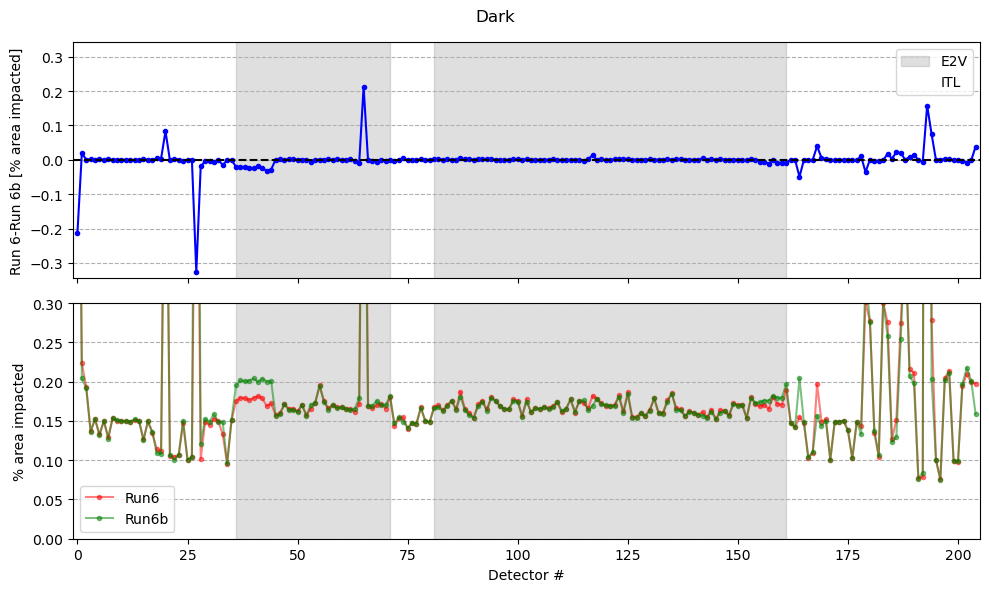

In [40]:
twoPanelFig("Dark",ylim2=[0,3E-1],ycol1="DarkPixels_percent_diff",ycol2=["Run6_DarkPixels_percent", 	"Run6b_DarkPixels_percent"],
            ylabel1="Run 6-Run 6b [% area impacted]",ylabel2="% area impacted",
            save=True,path="/home/s/seanmacb/Run6Comparisons/Figures/AdvancedStats/Dark_")

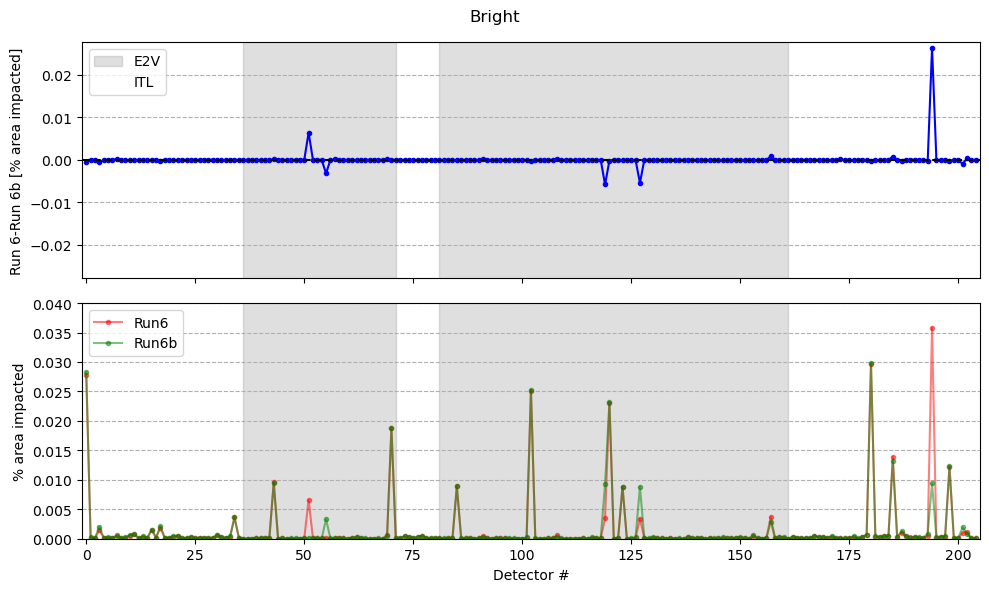

In [41]:
twoPanelFig("Bright",ylim2=[0,4E-2],ycol1="BrightPixels_percent_diff",
            ycol2=["Run6_BrightPixels_percent", 	"Run6b_BrightPixels_percent"],
            ylabel1="Run 6-Run 6b [% area impacted]",ylabel2="% area impacted",
            save=True,path="/home/s/seanmacb/Run6Comparisons/Figures/AdvancedStats/Bright_")

In [150]:
vert_scale = 1.05

colorbase = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#ffff33","#a65628","#f781bf"]

kwargs1 = {
    "color": colorbase[0],
    "ls": '-',
    "marker":"."
}

kwargs2 = {
    "color": colorbase[1],
    "ls": '--'
}

kwargs3 = {
    "ls": '-',
    "marker":".",
    'alpha':0.5
}
colors = [colorbase[1],colorbase[0]]

def twoPanelFigGeneral(supertitle,vert_scale = 1.05,ylim1=[0,1],ylim2=[0,5E5],ycol1=None,ycol2=None,
                ylabel1="Run 6-Run 6b [# pixels]",ylabel2=None,
                save=False,path=None):
    # Dark, two rows, one column
    # upper panel has difference in darks
    # Lower panel has raw numbers for darks

    '''
    Inputs:
    observable: String, used for title and for querying the dataset
    Returns:
    
    '''

    if ycol1==None:
        return -1
    if ycol2==None:
        return -1
    if ylabel2==None:
        return -1
    
    fig,axs = plt.subplots(2,1,figsize=[10,6],sharex=True)
    
    # fig.suptitle(supertitle)
    
    # Upper panel
    iter = 0 
    for run in ["Run6_","Run6b_"]:
        axs[0].plot(df["DetectorNumber"],df[ycol1[iter]],label=run[:-1],**kwargs3,c=colors[iter])
        iter+=1
    del iter
    
    # axs[0].axhline(0,**kwargs2) # probably don't want this
    axs[0].set_ylim(ylim1)
    axs[0].set_ylabel(ylabel1)
    
    axs[0].fill_between(df["DetectorNumber"], ylim1[0],
                        ylim1[1], where=df["Manufacturer"] != "ITL",
                        color='grey', alpha=0.25,label="E2V")
    axs[0].fill_between(df["DetectorNumber"] + 5E5,  ylim1[0],
                        ylim1[1], where=df["Manufacturer"] == "ITL",
                        color='white', alpha=0.25,label="ITL",edgecolor='black')
    
    # axs[0].legend()
    
    # Lower panel
    iter = 0 
    for run in ["Run6_","Run6b_"]:
        axs[1].plot(df["DetectorNumber"],df[ycol2[iter]],label=run[:-1],**kwargs3,c=colors[iter])
        iter+=1
    del iter
    axs[1].set_ylim(ylim2)
    # axs[1].legend()
    axs[1].set_ylabel(ylabel2)
    axs[1].set_xlabel("Detector #")
    axs[1].set_xlim(-1,max(df['DetectorNumber'])+1)

    axs[1].fill_between(df["DetectorNumber"], ylim2[0],
                        ylim2[1], where=df["Manufacturer"] != "ITL",
                        color='grey', alpha=0.25,label="E2V")
    axs[1].fill_between(df["DetectorNumber"],  ylim2[0],
                        ylim2[1], where=df["Manufacturer"] == "ITL",
                        color='white', alpha=1,label="ITL")
    
    # axs[1].fill_between(df["DetectorNumber"], -vert_scale*np.max(np.abs(df[ycol2])),
                        # vert_scale*np.max(np.abs(df[ycol2])), where=df["Manufacturer"] != "ITL",
                        # color='grey', alpha=0.25, transform=axs[1].get_xaxis_transform())
    axs[0].legend(ncol=2)
    
    # Final formatting
    
    for ax in axs:
        
        ax.grid(ls='--',axis='y')
    
    fig.tight_layout()
    
    plt.show()

    if save:
        fig.savefig(path+"Two_Panel.jpg",dpi=180)
    
    plt.close(fig)

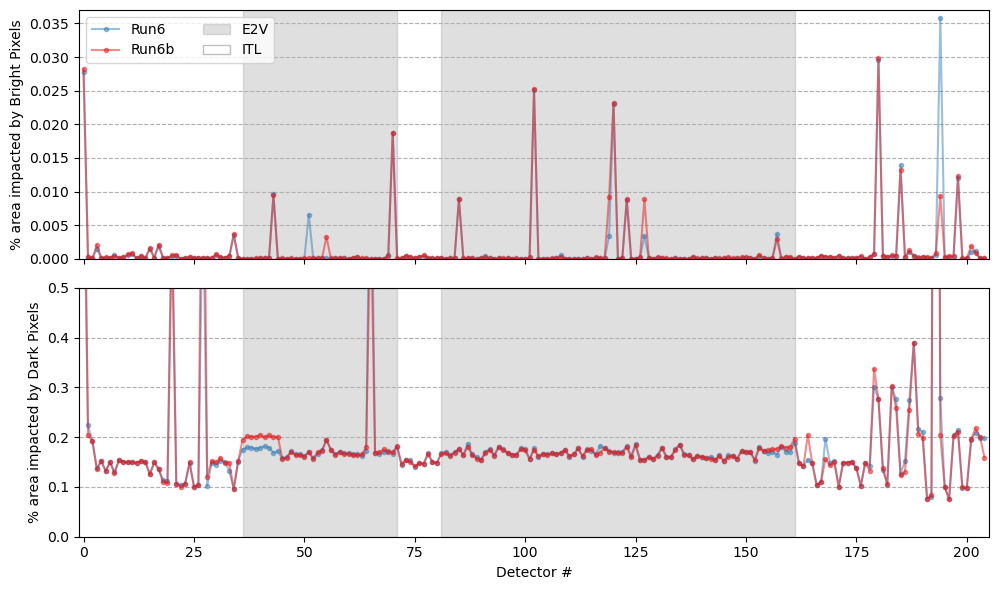

In [153]:
twoPanelFigGeneral("Bright and Dark",ylim1=[0,0.037],ylim2=[0,0.5],ycol1=["Run6_BrightPixels_percent", 	"Run6b_BrightPixels_percent"],
            ycol2=["Run6_DarkPixels_percent", 	"Run6b_DarkPixels_percent"],
            ylabel1="% area impacted by Bright Pixels",ylabel2="% area impacted by Dark Pixels",
            save=True,path="/home/s/seanmacb/Run6Comparisons/Figures/AdvancedStats/Dark_And_Bright")

In [164]:
option = ["Run6_BrightPixels_percent", 	"Run6b_BrightPixels_percent","Run6_DarkPixels_percent", 	"Run6b_DarkPixels_percent"]

for o in option:
    print("ITL",o,np.median(df[df["Manufacturer"]=="ITL"][o]))
    print("E2V",o,np.median(df[df["Manufacturer"]=="E2V"][o]))

ITL Run6_BrightPixels_percent 0.00021181237721021613
E2V Run6_BrightPixels_percent 5.4876763861138866e-05
ITL Run6b_BrightPixels_percent 0.0002425098231827112
E2V Run6b_BrightPixels_percent 7.316901848151848e-05
ITL Run6_DarkPixels_percent 0.14893786836935166
E2V Run6_DarkPixels_percent 0.16851434698114384
ITL Run6b_DarkPixels_percent 0.1490191861739838
E2V Run6b_DarkPixels_percent 0.1688375101461039


In [42]:
df

,Run6_DarkPixels,Run6b_DarkPixels,Run6_BrightPixels,Run6b_BrightPixels,Manufacturer,DarkDifference,BrightDifference,Raft,DetectorNumber,DetectorSize,Run6_DarkPixels_percent,Run6b_DarkPixels_percent,DarkPixels_percent_diff,Run6_BrightPixels_percent,Run6b_BrightPixels_percent,BrightPixels_percent_diff
R01_S00,124470,159121,4514,4605,ITL,-34651,-91,R01,0,16288000,0.764182,0.976922,-0.212739,0.027714,0.028272,-0.000559
R01_S01,36403,33255,33,34,ITL,3148,-1,R01,1,16288000,0.223496,0.204169,0.019327,0.000203,0.000209,-0.000006
R01_S02,31398,31264,11,14,ITL,134,-3,R01,2,16288000,0.192768,0.191945,0.000823,0.000068,0.000086,-0.000018
R01_S10,22361,22106,241,335,ITL,255,-94,R01,3,16288000,0.137285,0.13572,0.001566,0.00148,0.002057,-0.000577
R01_S11,24805,24798,28,29,ITL,7,-1,R01,4,16288000,0.15229,0.152247,0.000043,0.000172,0.000178,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R40_SW1,15874,16030,11,12,ITL,-156,-1,R40,200,16288000,0.097458,0.098416,-0.000958,0.000068,0.000074,-0.000006
R44_SG0,31710,32082,157,313,ITL,-372,-156,R44,201,16288000,0.194683,0.196967,-0.002284,0.000964,0.001922,-0.000958
R44_SG1,34077,35453,192,139,ITL,-1376,53,R44,202,16288000,0.209215,0.217663,-0.008448,0.001179,0.000853,0.000325
R44_SW0,16230,16383,5,5,ITL,-153,0,R44,203,8144000,0.199288,0.201167,-0.001879,0.000061,0.000061,0.0


In [481]:
df[np.abs(df["DarkPixels_percent_diff"])>0.05]["DetectorNumber"].array

<PandasArray>
[0, 20, 27, 65, 193, 194]
Length: 6, dtype: int64

In [482]:
df[np.abs(df["BrightPixels_percent_diff"])>1E-3]["DetectorNumber"].array

<PandasArray>
[51, 55, 119, 127, 194]
Length: 5, dtype: int64

In [478]:
16288000*0.001

16288.0

In [483]:
1E-3

0.001

In [484]:
0.0001*16288000

1628.8000000000002

In [169]:
df[['Manufacturer',"DetectorNumber"]][0:50]

,Manufacturer,DetectorNumber
R01_S00,ITL,0
R01_S01,ITL,1
R01_S02,ITL,2
R01_S10,ITL,3
R01_S11,ITL,4
R01_S12,ITL,5
R01_S20,ITL,6
R01_S21,ITL,7
R01_S22,ITL,8
R02_S00,ITL,9


In [167]:
df

,Run6_DarkPixels,Run6b_DarkPixels,Run6_BrightPixels,Run6b_BrightPixels,Manufacturer,DarkDifference,BrightDifference,Raft,DetectorNumber,DetectorSize,Run6_DarkPixels_percent,Run6b_DarkPixels_percent,DarkPixels_percent_diff,Run6_BrightPixels_percent,Run6b_BrightPixels_percent,BrightPixels_percent_diff
R01_S00,124470,159121,4514,4605,ITL,-34651,-91,R01,0,16288000,0.764182,0.976922,-0.212739,0.027714,0.028272,-0.000559
R01_S01,36403,33255,33,34,ITL,3148,-1,R01,1,16288000,0.223496,0.204169,0.019327,0.000203,0.000209,-0.000006
R01_S02,31398,31264,11,14,ITL,134,-3,R01,2,16288000,0.192768,0.191945,0.000823,0.000068,0.000086,-0.000018
R01_S10,22361,22106,241,335,ITL,255,-94,R01,3,16288000,0.137285,0.13572,0.001566,0.00148,0.002057,-0.000577
R01_S11,24805,24798,28,29,ITL,7,-1,R01,4,16288000,0.15229,0.152247,0.000043,0.000172,0.000178,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R40_SW1,15874,16030,11,12,ITL,-156,-1,R40,200,16288000,0.097458,0.098416,-0.000958,0.000068,0.000074,-0.000006
R44_SG0,31710,32082,157,313,ITL,-372,-156,R44,201,16288000,0.194683,0.196967,-0.002284,0.000964,0.001922,-0.000958
R44_SG1,34077,35453,192,139,ITL,-1376,53,R44,202,16288000,0.209215,0.217663,-0.008448,0.001179,0.000853,0.000325
R44_SW0,16230,16383,5,5,ITL,-153,0,R44,203,8144000,0.199288,0.201167,-0.001879,0.000061,0.000061,0.0
